# Generative modeling in deep learning

*This notebook consists of common introductory questions, followed by 4 different generative models (GAN, VAE, Flow matching, Diffusion flow), and a common conclusive question. **Choose & implement 2 among the 4 models**, not all of them! If you train more models, write down below the 2 ones you want to be graded on. Do not forget the last common question.*

Generative modeling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modeling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modeling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

<style>
    .cyan {
        background-color: #33f6ff;
    }
    
</style>

<span style="color:black">

<div class="cyan">

There are many ways to compare two probability distributions $P$ and $Q$. One can compare their difference $P-Q$, their ratio $\frac{P}{Q}$ (where and if it makes sense), and the metric can be either a $\textit{divergence}$ or a $\textit{distance}$, depending on whether the metric is symetric or not.

A $\textbf{divergence}$ compare two distributions in terms of their density ration $\frac{p(x)}{q(x)}$. The general formulation of a divergence is, with $f:\mathbb{R}_+ \longrightarrow \mathbb{R}$ convex and satisfying $f(1)=0:

\begin{align*}
        D_f(p \vert\vert q) = \int q(x) f \left( \frac{p(x)}{q(x)} \right) dx
\end{align*}

The most famous divergence is the $\textbf{Kullback Leibler}$ divergence, with $f = \text{log}$ :
\begin{align*}
        D_{\mathbb{KL}}(p \vert\vert q) = \int p(x) \text{log} \, \left( \frac{p(x)}{q(x)} \right) dx
\end{align*}

Other functions $f$ lead to other divergences (or in some cases distances) : Alpha divergence, Hellinger distance, $\mathcal{X}^2$ distance, etc.


An $\textbf{Integral Probability Metric}$ is a computation on $P - Q$. The general formulation is :

\begin{align*}
        D_{\mathcal{F}}(P \vert\vert Q) = \underset{f \in \mathcal{F}}{\text{sup}} \,\, \left( \mathbb{E}_{X \sim P} f(X) - \mathbb{E}_{X' \sim Q} f(X') \right)
\end{align*}

where $\mathcal{F}$ is a class of "smooth" functions. The obvious advantage here is that IPM require "only" the ability to sample from $P$ and $Q$ to be computed, and not the knowledge of $p(x)$ or $q(x)$.

When $\mathcal{F}$ is the class of 1-Lipschitz functions, one gets the $\textbf{Wasserstein-1}$ distance:

\begin{align*}
W_1(P, Q) = \underset{\vert\vert f \vert\vert_L \leq 1}{\text{sup}} \,\, \left( \mathbb{E}_{X \sim P} f(X) - \mathbb{E}_{X' \sim Q} f(X') \right)
\end{align*}

We also saw in the Kernel class, that when $\mathcal{F}$ is the RKHS (Reproducing Kernel Hilbert Space) associated to a positive definite kernel, the IPM produces a $\textbf{Maximum Mean Discrepancy}$ metric, that gives rise to $\textit{Kernel Mean embedding}$ of distributions, and can be computed via the Kernel trick.

</div>
</span>

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

<style>
    .cyan {
        background-color: #33f6ff;
    }
    
</style>

<span style="color:black">

<div class="cyan">

A couple of things need to be taken into account :

* $\textbf{Differentiability}$ - the computation of the difference between the two probability distributions will be used as a loss function to train a network, and that loss function needs to be differentiable so we can backprop gradients.

* $\textbf{Supports}$ - one issue can arise when $P$ and $Q$ have, or are sampled from, different supports. In the case of the ${\mathcal{KL}}$-divergence for example, numerical issues can arise when $p(x) \sim 0$ and $q(x) \gg 0$ or vice versa (see issues associated to Jensen-Shannon in GANs for example).

* $\textbf{Generalization}$ - in the case of computing a numerical approximation of an integral over samples, the sampling method needs to be robust enough so the sampling is actually representative of the support of the distributions.

</div>
</span>

In this work, we will focus on the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GAN), Variational AutoEncoders (VAE), Flow Matching and Diffusion Models, in order to compare them and understand their strengths and weaknesses.

## Dataset

#### Checkerboard (prioritize this dataset)

In [1]:
import torch
import math
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

def generate_batch(num_datapoints: int) -> np.ndarray:
  """Checkerboard dataset."""
  x1 = np.random.rand(num_datapoints) * 4 - 2
  x2 = np.random.rand(num_datapoints) - np.random.randint(0, 2, [num_datapoints]) * 2. + np.floor(x1) % 2
  data = np.stack([x1, x2]).T * 2
  data = (data - data.mean(axis=0)) / data.std(axis=0) # normalize
  return torch.from_numpy(data.astype(np.float32))

train_data = generate_batch(5000)

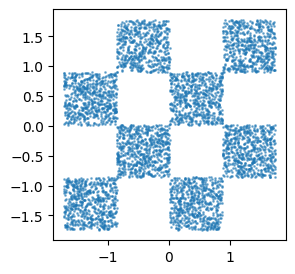

In [2]:
plt.figure(figsize=(3, 3))
plt.scatter(train_data.numpy()[:,0], train_data.numpy()[:,1], s=1.0, alpha=0.5)
plt.show()

It's also good to visualize the density as sometimes generative models overfit particular region of space. Once models are trained, when you sample from them, plot the two densities side-by-side to compare real & synthetic dataset.

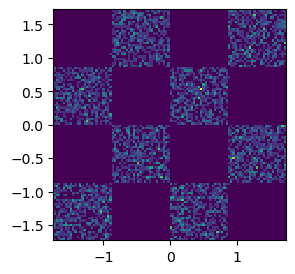

In [3]:
plt.figure(figsize=(3, 3))
plt.hist2d(train_data.numpy()[:,0], train_data.numpy()[:,1], bins=100)
plt.show()

#### Moon (use this one only if your models struggle on checkerboard)

In [3]:
import torch
import math
from sklearn import datasets
import numpy as np

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

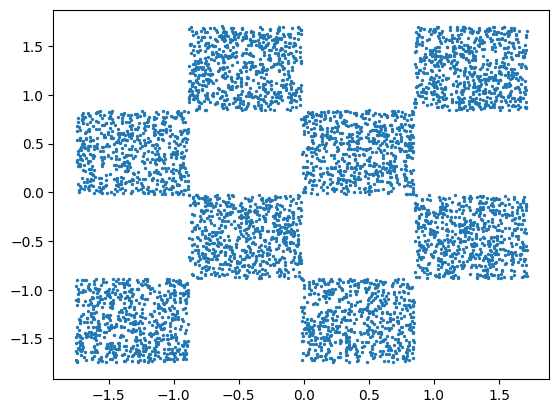

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

It's also good to visualize the density as sometimes generative models overfit particular areas. Once models are trained, when you sample from them, plot the two densities side-by-side to compare real & synthetic dataset.

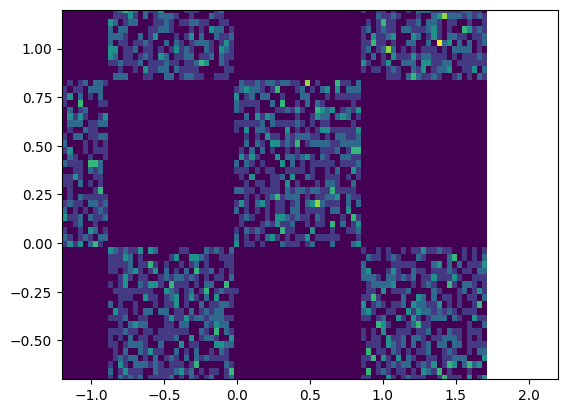

In [4]:
plt.hist2d(batch.numpy()[:,0], batch.numpy()[:,1], bins=100)
plt.xlim([-1.2,2.2])
plt.ylim([-0.7,1.2])
plt.show()

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(f"Using {device}")

Using cpu


----
## Generative Adversarial Networks

GANs structure is based on modeling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

<style>
    .cyan {
        background-color: #33f6ff;
    }
    
</style>

<span style="color:black">

<div class="cyan">

The $\textbf{dimension of the input noise}$ is going to impact, a priori, the $\textbf{expressiveness}$ of the generator (the higher the dimension, the more expressive the generator is likely to be), and, consequently, the $\textbf{easiness}$ or $\textbf{difficulty}$ to train $f_{\theta}$.
Furthermore, a $\textbf{high latent dimension}$ can also increase the risk of $\textbf{overfitting}$ or lead to issues like $\textbf{mode collapse}$ if the discriminator does not provide a rich signal.

</div>
</span>

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

<style>
    .cyan {
        background-color: #33f6ff;
    }
    
</style>

<span style="color:black">

<div class="cyan">

The issue arises when we consider the supports of $p_{\theta}$ and $p_D$.

When we sample the data from the original data, the support $\text{supp}(p_D)$ of the empirical distribution $p_D$ is discrete -by construction. If $p_{\theta} = 0$ on $\text{supp}(p_D)$, then the optimal $D^*(x) = 1$ on "real" data, and $0$ on "fake" (generated) data. This implies numerically, that $D^*$ is about constant around either real data points or generated data points, therefore with $\textit{vanishing}$ gradients, which complicate training.

In that case, we also see the Jensen Shannon Divergence is going to take the optimal value $\text{log}2$ irregardless of how far the supports of $p_D$ and $p_{\theta}$ are, which is not very informative.

</div>
</span>

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

<style>
    .cyan {
        background-color: #33f6ff;
    }
    
</style>

<span style="color:black">

<div class="cyan">

A problem can arise when the Generator is trained faster than the Discrimator, or vice-versa. In practive, both networks need to be trained "on par", ie in such a way that none becomes too efficient too soon and prevent the other from training.

</div>
</span>

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 2)
        
    def __call__(self, z):
        return self.fc1(z)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 1)
    
    def __call__(self, x):
        return self.fc1(x)

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

step 0: discriminator: nan, generator: nan


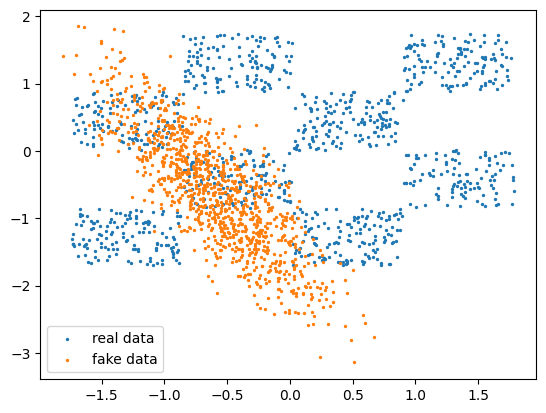

step 1000: discriminator: nan, generator: nan


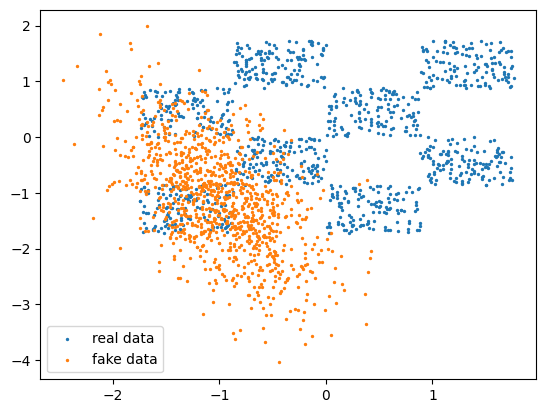

step 2000: discriminator: nan, generator: nan


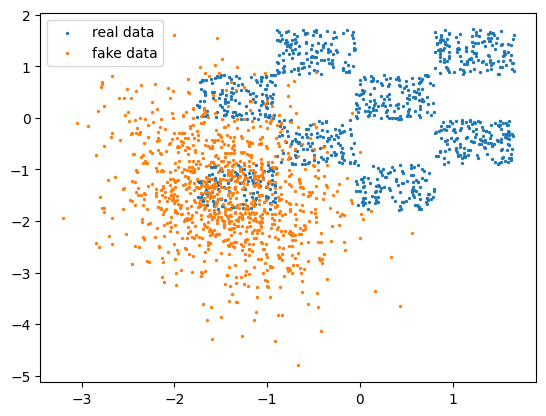

step 3000: discriminator: nan, generator: -4.423e-01


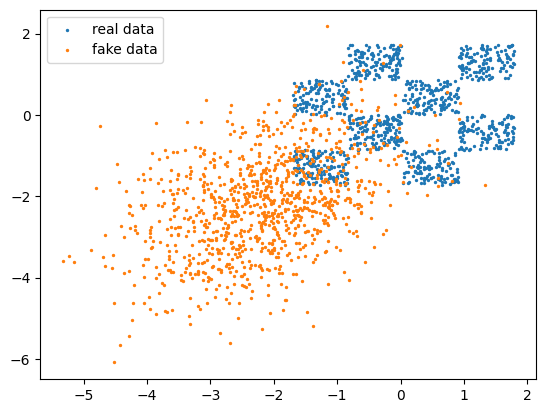

step 4000: discriminator: nan, generator: 1.023e+00


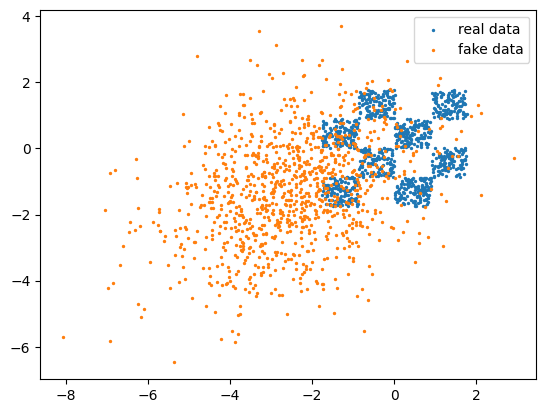

step 5000: discriminator: nan, generator: 1.285e+00


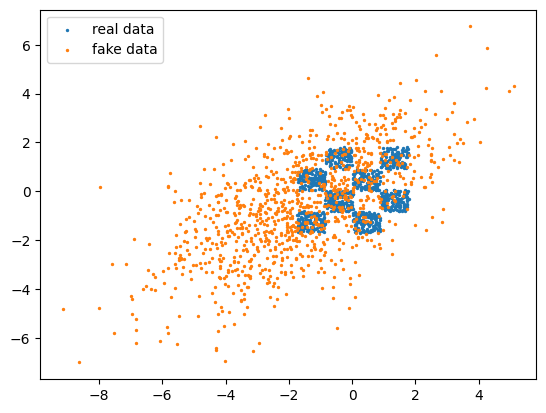

step 6000: discriminator: nan, generator: 1.372e+00


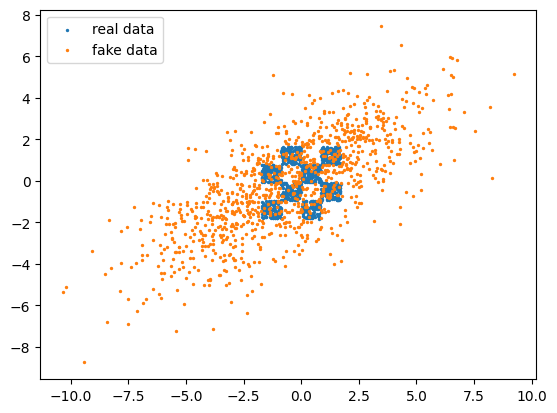

step 7000: discriminator: nan, generator: 1.582e+00


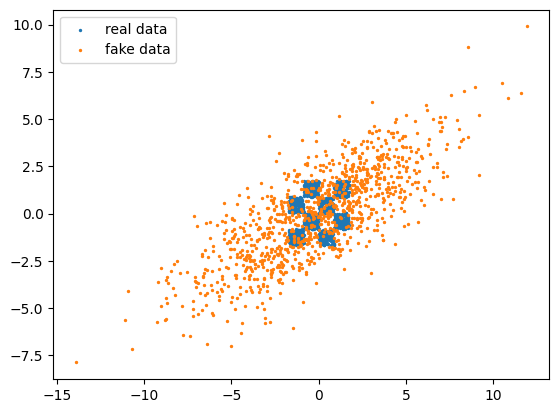

step 8000: discriminator: nan, generator: 1.769e+00


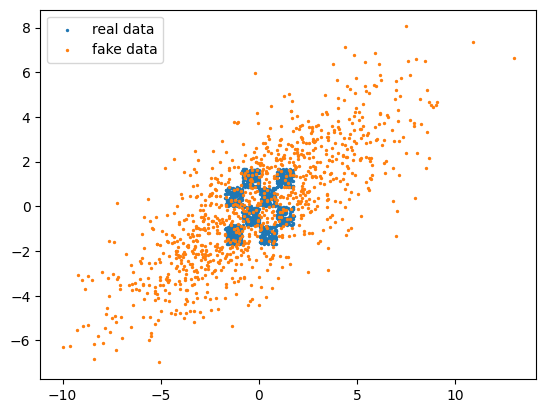

step 9000: discriminator: nan, generator: 1.926e+00


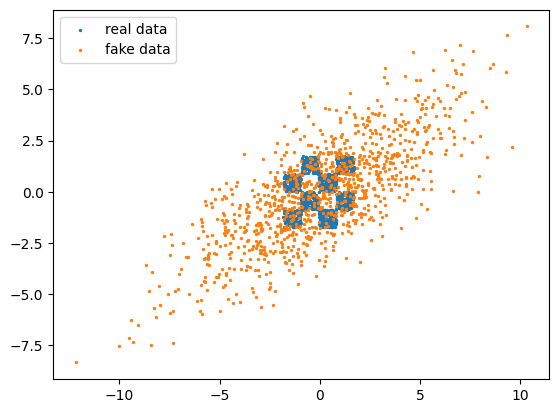

step 10000: discriminator: nan, generator: 2.061e+00


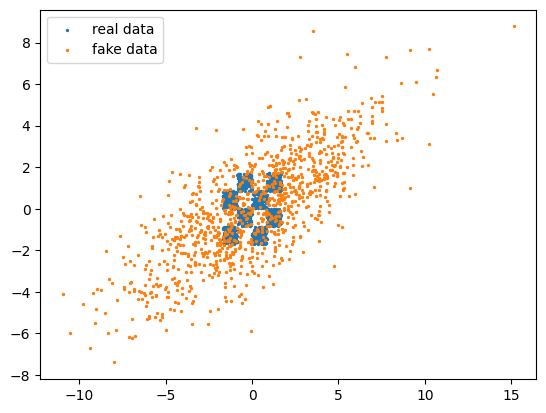

step 11000: discriminator: nan, generator: 2.181e+00


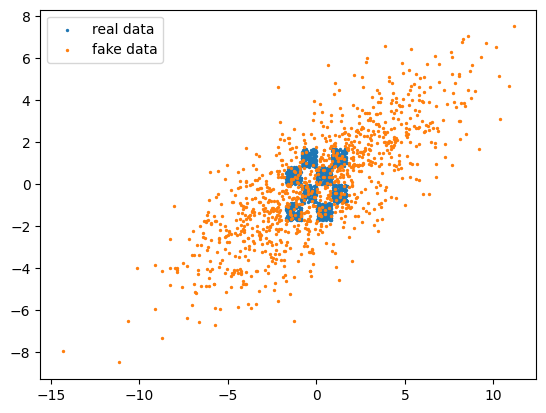

step 12000: discriminator: nan, generator: 2.288e+00


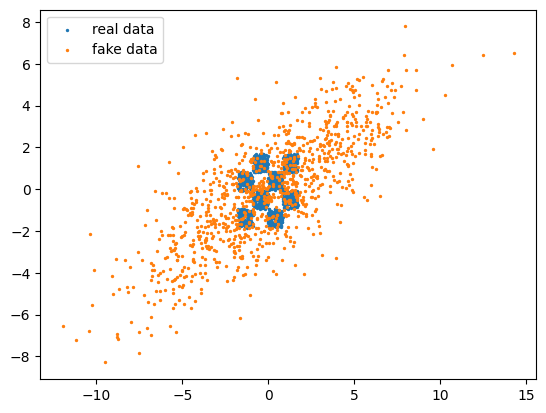

step 13000: discriminator: nan, generator: 2.385e+00


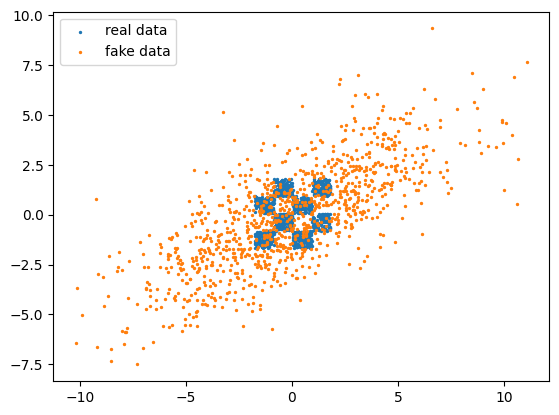

step 14000: discriminator: nan, generator: 2.473e+00


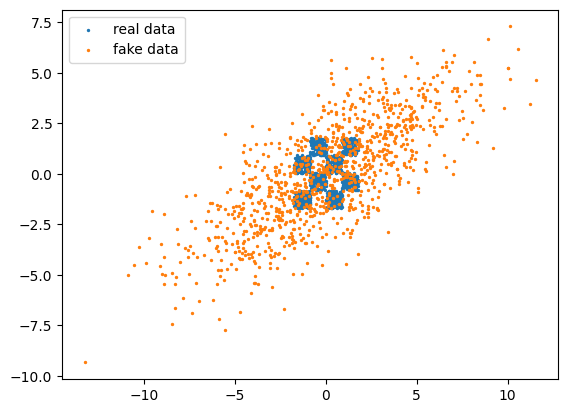

step 15000: discriminator: nan, generator: 2.554e+00


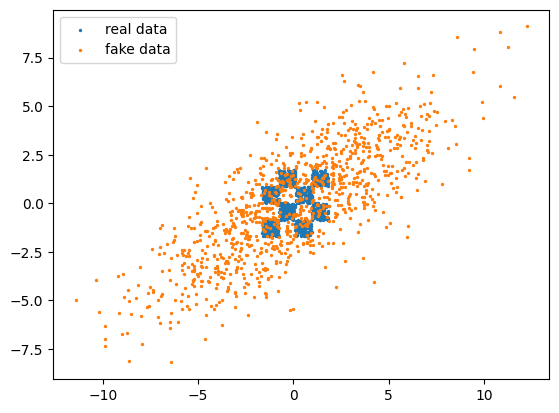

step 16000: discriminator: nan, generator: 2.629e+00


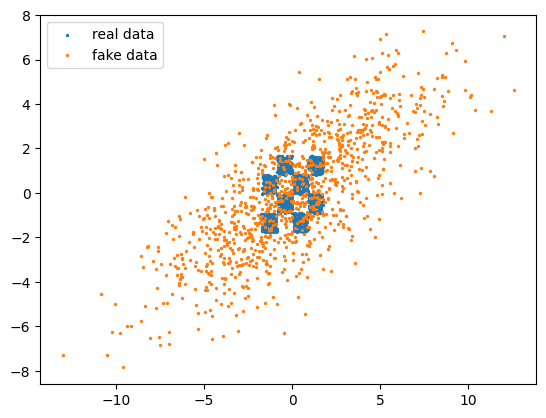

step 17000: discriminator: nan, generator: 2.698e+00


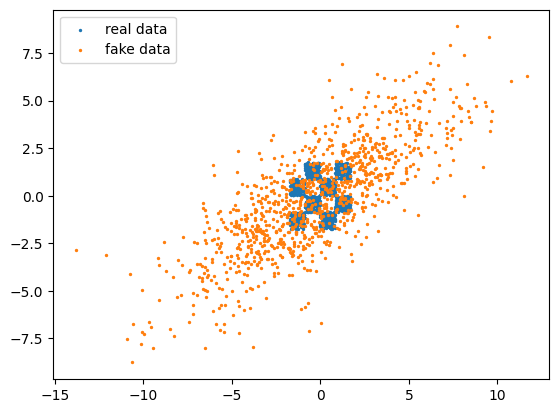

step 18000: discriminator: nan, generator: 2.763e+00


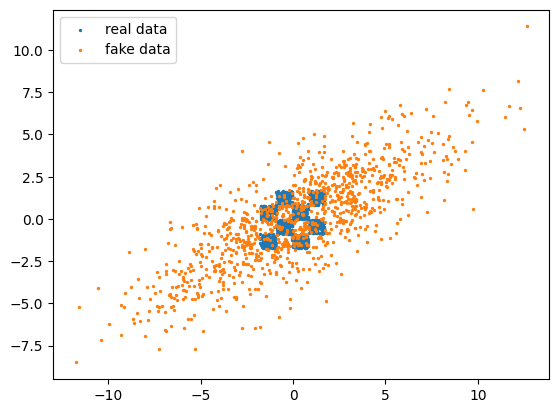

step 19000: discriminator: nan, generator: 2.824e+00


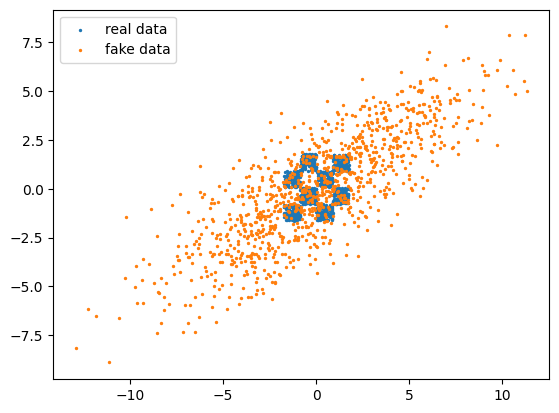

step 20000: discriminator: nan, generator: 2.882e+00


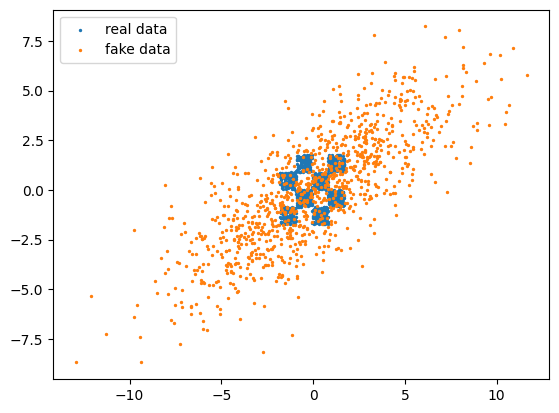

In [7]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE DISCRIMINATOR LOSS HERE ==
        disc_loss = -torch.mean(torch.log(discriminator(real_batch)) + torch.log(1 - discriminator(fake_batch)))
        #
        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    #
    # == COMPUTE THE GENERATOR LOSS HERE
    gen_loss = torch.mean(torch.log(1-discriminator(fake_batch)))
    #
    gen_loss.backward()
    optim_gen.step()
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

<style>
    .cyan {
        background-color: #33f6ff;
    }
    
</style>

<span style="color:black">

<div class="cyan">

As seen in $\textbf{Q4}$, the optimal discriminator $D^*$, or a very well trained discriminator for that matter, is going to lead to $D^*$ being about constant =1 around real data points and =0 around generated data points, therefore with $\textit{vanishing}$ gradients. As a result, the generator can not train.
We can also note that since no sigmoid nor BCEWithLogits loss is used, we get out of range support for $D$ (outside of [0,1] ) therefore the discriminator's losses values are NaN which can also cause numerical issues.
</div>
</span>

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

In [12]:
# Define the generator
class Generator2(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 2)
        
    def __call__(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        z = self.fc3(z)
        return z
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator2(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
    
    def __call__(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

step 0: discriminator: 1.412e+00, generator: 8.119e-01


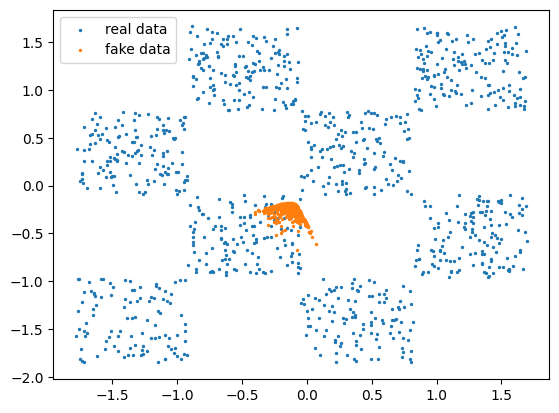

step 1000: discriminator: 1.382e+00, generator: 6.750e-01


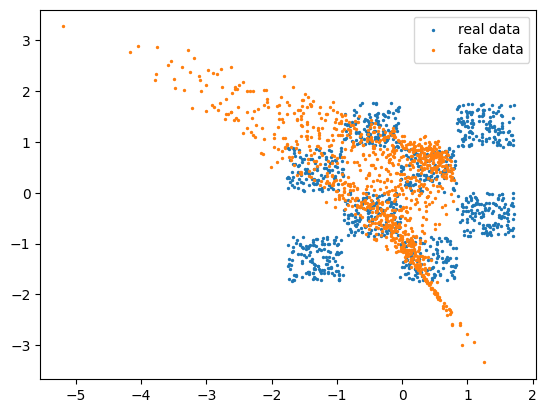

step 2000: discriminator: 1.394e+00, generator: 7.436e-01


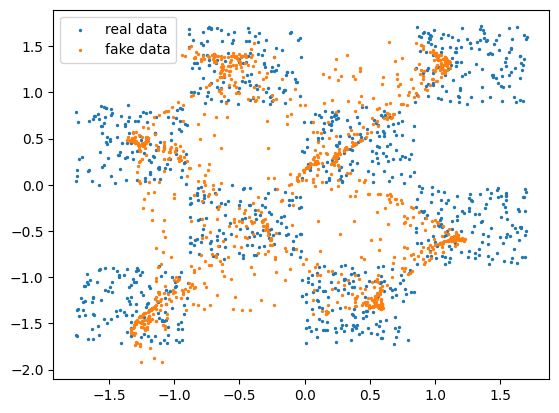

step 3000: discriminator: 1.387e+00, generator: 7.165e-01


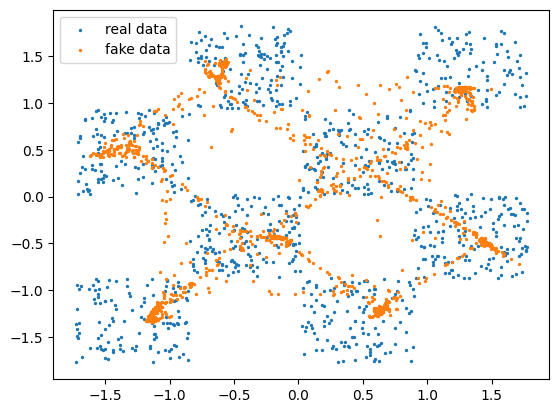

step 4000: discriminator: 1.388e+00, generator: 7.158e-01


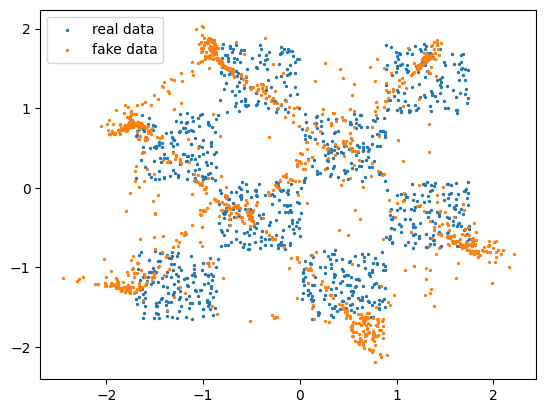

step 5000: discriminator: 1.389e+00, generator: 6.905e-01


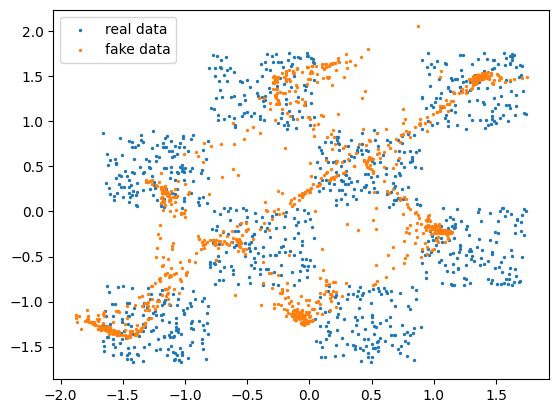

step 6000: discriminator: 1.385e+00, generator: 7.006e-01


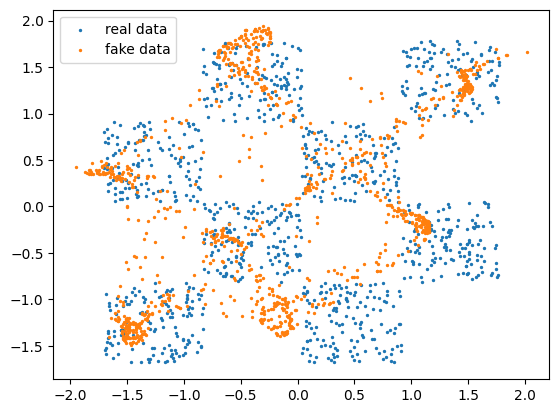

step 7000: discriminator: 1.390e+00, generator: 6.891e-01


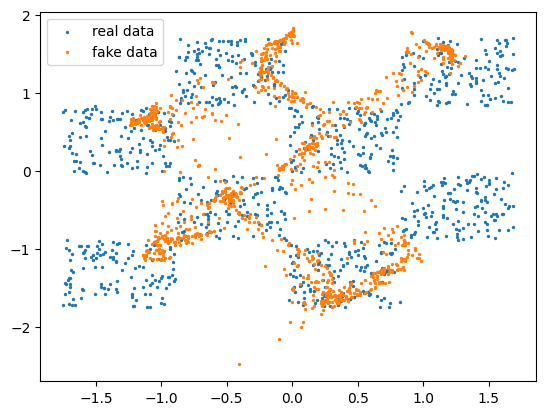

step 8000: discriminator: 1.386e+00, generator: 6.967e-01


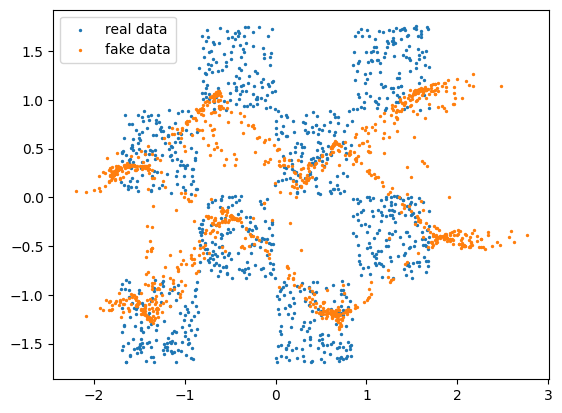

step 9000: discriminator: 1.387e+00, generator: 6.794e-01


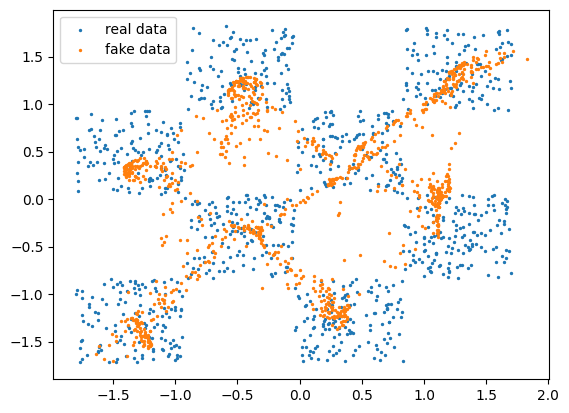

step 10000: discriminator: 1.389e+00, generator: 7.059e-01


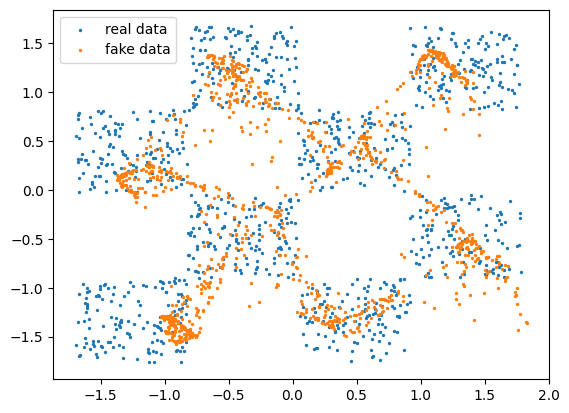

step 11000: discriminator: 1.392e+00, generator: 7.085e-01


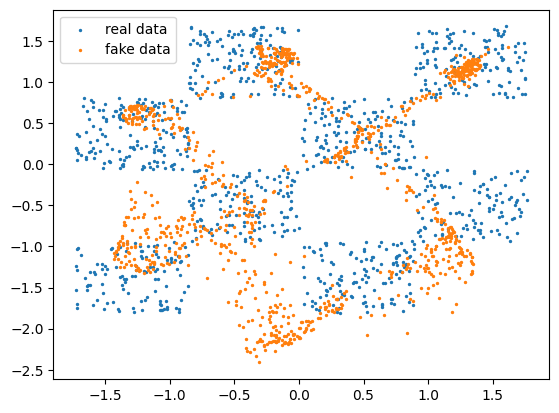

step 12000: discriminator: 1.387e+00, generator: 6.837e-01


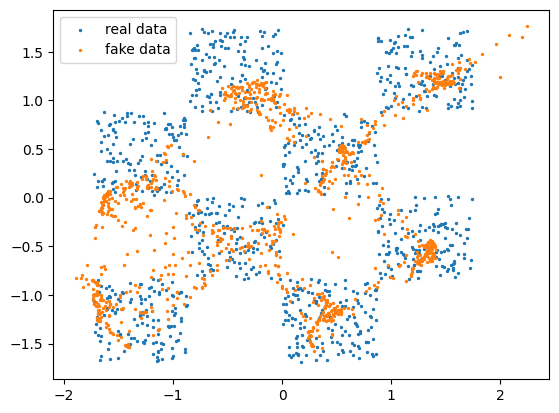

step 13000: discriminator: 1.382e+00, generator: 7.365e-01


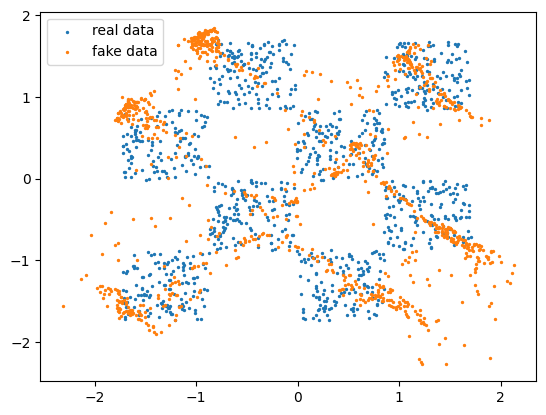

step 14000: discriminator: 1.405e+00, generator: 6.945e-01


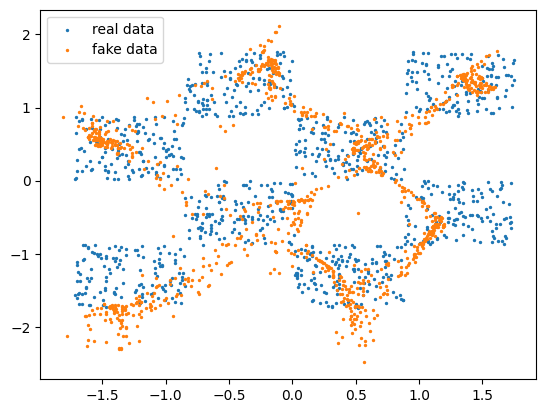

step 15000: discriminator: 1.389e+00, generator: 6.987e-01


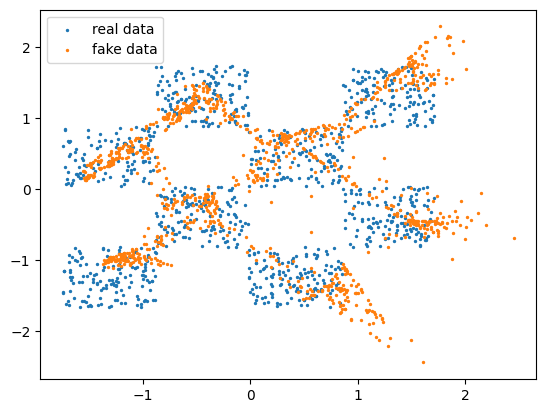

step 16000: discriminator: 1.384e+00, generator: 7.019e-01


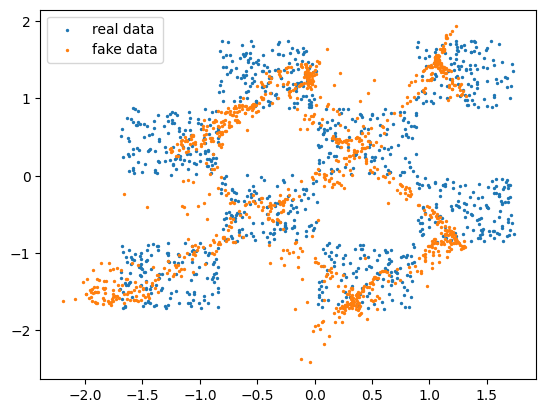

step 17000: discriminator: 1.385e+00, generator: 6.909e-01


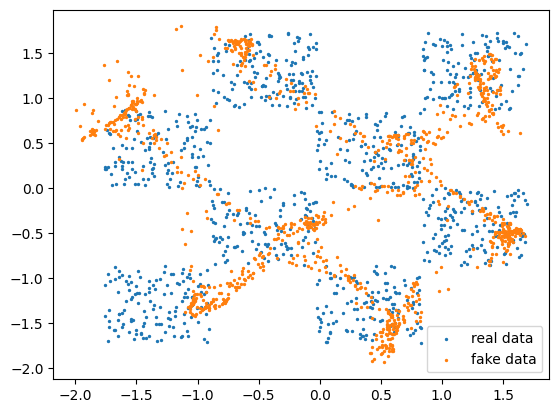

step 18000: discriminator: 1.384e+00, generator: 6.816e-01


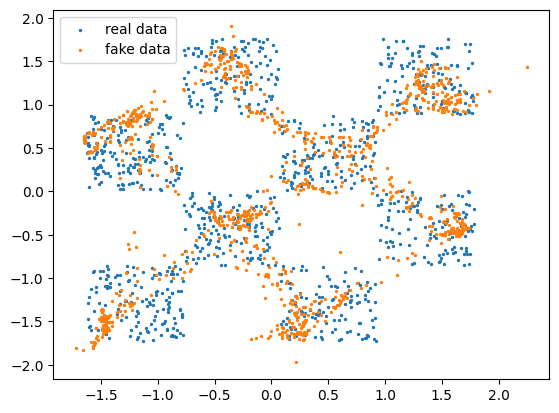

step 19000: discriminator: 1.393e+00, generator: 6.900e-01


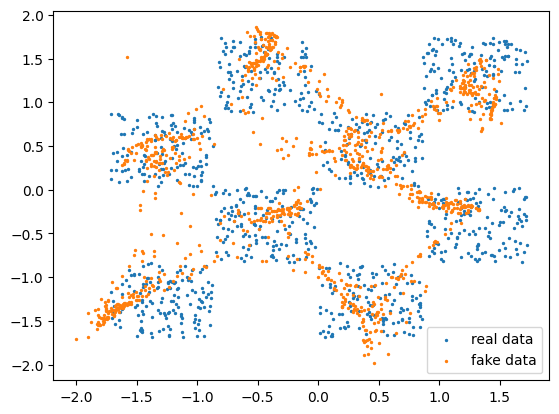

step 20000: discriminator: 1.387e+00, generator: 6.980e-01


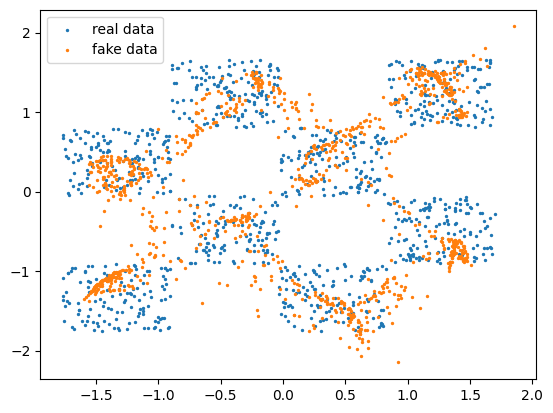

In [14]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

generator = Generator2()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
discriminator = Discriminator2()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE DISCRIMINATOR LOSS HERE ==
        #disc_loss = -torch.mean(torch.log(discriminator(real_batch)) + torch.log(1 - discriminator(fake_batch))) # use BCEWithLogitsLoss
        disc_loss = F.binary_cross_entropy_with_logits(discriminator(real_batch), torch.ones(BATCHLEN, 1)) + F.binary_cross_entropy_with_logits(discriminator(fake_batch), torch.zeros(BATCHLEN, 1))
        
        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    #
    # == COMPUTE THE REFORMULATED GENERATOR LOSS HERE
    #gen_loss = torch.mean(torch.log(-discriminator(fake_batch)))
    #use BCEWithLogitsLoss
    gen_loss = F.binary_cross_entropy_with_logits(discriminator(fake_batch), torch.ones(BATCHLEN, 1))
    #
    gen_loss.backward()
    optim_gen.step()
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

<style>
    .cyan {
        background-color: #33f6ff;
    }
    
</style>

<span style="color:black">

<div class="cyan">

Training a GAN with loss functions derived from the JSD formulation remains extremely difficult as it is quite unstable. 

A good way around is to use a loss function based on the $\textbf{Wasserstein-1}$ distance, which has good continuity properties. One then needs to enforce that the discriminator is $1$-Lipschitz, with a $\textit{Gradient Penalty}$ regularization term. The loss function becomes:

\begin{align}
\mathcal{L} = \underset{\text{D}}{\text{sup}} \,\, \left( \mathbb{E}_{X \sim p_D} D(X) - \mathbb{E}_{X \sim p_{\theta}} D(X) \right) - \lambda \mathbb{E}_{X \sim \mathcal{U(p_D, p_{\theta})}}((\vert\vert \nabla D(X)\vert\vert-1 )^2)
\end{align}

Where the expectation of the gradient of the discrimator is computed by averaging gradients on interpolations between the real data and the generated one.

</div>
</span>

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
- A Style-Based Generator Architecture for Generative Adversarial Networks *(Karras et al.)* [arxiv:1812.04948v3](https://arxiv.org/abs/1812.04948v3)

----
## Variational AutoEncoders

Another well-known approach to generative modeling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

<style>
    .cyan {
        background-color: #33f6ff;
    }
    
</style>

<span style="color:black">

<div class="cyan">

\begin{align}
\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ] &= \int p_D(x) \log p_\theta(x) dx \\
&= \int p_D(x) \log \left( \frac{p_\theta(x)}{p_D(x)}p_D(x) \right) dx \\
&= \int p_D(x) \log \left( \frac{p_\theta(x)}{p_D(x)} \right) dx + \int p_D(x) \log p_D(x) dx \\
&= -D_{KL}(p_D \| p_\theta) - \mathcal{H}(p_D)
\end{align}

Where $\mathcal{H}(p_D)$ is the entropy of $p_D$, which is a constant.
</div>
</span>

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](./vae-gaussian.png)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

<style>
    .cyan {
        background-color: #33f6ff;
    }
    
</style>

<span style="color:black">

<div class="cyan">

We see in the ELBO formulation that $p(z)$ appears only in $D_{KL}(q_\phi(z | x) \| p(z))$. Here, the two distributions are Gaussians, and the $\mathbb{KL}$ has a close form expression that requires only the means and the covariance matrixes. Those are known for $p(z)$.

Another point is that, when we need to compute the gradient $\nabla_{\phi}$ to train the encoder, the expectations are computed wrt $z$ which is drawn from a distribution whose parameters depend on $\phi$. Therefore we need to use the $\textit{reparametrization trick}$ to be able to compute the gradient.
</div>
</span>

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

<style>
    .cyan {
        background-color: #33f6ff;
    }
    
</style>

<span style="color:black">

<div class="cyan">

Recall that the KL-divergence between two Gaussians $\mathcal{N}_1(\mu_1, \Sigma_1)$ and $\mathcal{N}_2(\mu_2, \Sigma_2)$ is:
\begin{align*}
\mathbb{KL}(\mathcal{N}_1 \vert\vert \mathcal{N}_2) &= \frac{1}{2}\left(
    \text{Trace}(\Sigma_2^{-1}\Sigma_1) - k + (\mu_2-\mu_1)^T\Sigma_2^{-1}(\mu_2-\mu_1) + \text{ln}(\frac{\vert \Sigma_2\vert}{\vert \Sigma_1 \vert})
    \right)
\end{align*}
where $k$ is the dimensionality of the two Gaussians.

Here, we have $\mu_2 = 0$ and $\Sigma_2 = Id_d$ with $d$ dimension of the latent space, therefore:

\begin{align*}
D_{KL}(q_\phi(z | x) \| p(z)) &= \frac{1}{2}\left(
    \text{Trace}(\text{Diag}(\sigma_{\phi}^2)) - d + \mu_{\phi}^T\mu_{\phi} - \text{ln}{\vert \Sigma_1 \vert} \right) \\
    &= \frac{1}{2}\left( \sum_{i=1}^l (\sigma_{\phi}^2)_i - d +\mu_{\phi}^T\mu_{\phi} - \sum_{i=1}^l \text{ln} (\sigma_{\phi}^2)_i \right)
\end{align*}

</div>
</span>

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

<style>
    .cyan {
        background-color: #33f6ff;
    }
    
</style>

<span style="color:black">

<div class="cyan">

By definition, $X \vert z \sim \mathcal{N}(\mu_{\theta}(z), \text{Diag}(\sigma_{\theta}^2(z)))$, so

\begin{align*}
p_{\theta}(x\vert z) &= \frac{1}{(2 \pi)^\frac{d}{2} \vert \text{Diag}(\sigma_{\theta}^2) \vert^{\frac{1}{2}}} \text{exp} \left( -\frac{1}{2} (x-\mu_{\theta}(z))^T \text{Diag}(\sigma_{\theta}^2(z))^{-1} (x-\mu_{\theta}(z)) \right) \\
\text{log} \,\, p_{\theta}(x\vert z) &= -\frac{d}{2} \text{log} \,\, (2 \pi) - \frac{1}{2} \sum_{i=1}^d \text{log} \, (\sigma_{\theta}^2)_i -\frac{1}{2} (x-\mu_{\theta}(z))^T \text{Diag}(\sigma_{\theta}^2(z))^{-1} (x-\mu_{\theta}(z)) \\
-\text{log} \,\, p_{\theta}(x\vert z) &= \frac{d}{2} \text{log} \,\, (2 \pi) + \frac{1}{2} \sum_{i=1}^d \text{log} \, (\sigma_{\theta}^2)_i +\frac{1}{2} (x-\mu_{\theta}(z))^T \text{Diag}(\sigma_{\theta}^2(z))^{-1} (x-\mu_{\theta}(z)) \\
\end{align*}

</div>
</span>

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [12]:
# Choose a value for the latent dimension
LATENT_N = 16

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(2, LATENT_N)
        self.fc_logvar = nn.Linear(2, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(LATENT_N, 2)
        self.fc_logvar = nn.Linear(LATENT_N, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0).to(device)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

In [13]:
def display_results(batch_size=1024, xlim=3.0, ylim=2.0):
    """Display the results of the training."""
    # sample real data
    real_batch = generate_batch(batch_size).to(device)

    # encode real data into latent space
    enc_mu, enc_logvar = encoder(real_batch)
    
    # sample from latent space
    z_batch = torch.normal(enc_mu, torch.exp(0.5*enc_logvar)).detach()

    # get parameters of the observation model from the decoder
    dec_mu, dec_logvar = decoder(z_batch)

    # sample from the observation model
    x_hat = dec_mu + torch.randn_like(dec_mu) * torch.exp(0.5*dec_logvar)
    rec_batch = x_hat.detach()

    # generate fake data
    fake_batch = decoder.generate(batch_size).detach()
    
    # go to cpu for display
    real_batch = real_batch.cpu()
    rec_batch = rec_batch.cpu()
    fake_batch = fake_batch.cpu()

    # plot everything
    plt.scatter(real_batch[:,0], real_batch[:,1], marker='x', color='blue', s=1.0, label='real data')
    plt.scatter(rec_batch[:,0], rec_batch[:,1], marker='o', color='green',  s=10.0, label='rec data')
    plt.scatter(fake_batch[:,0], fake_batch[:,1], marker='.', color='red', s=10.0, label='fake data')
    plt.xlim([0.5-xlim,0.5+xlim])
    plt.ylim([0.25-ylim,0.25+ylim])
    plt.grid()
    plt.legend()
    plt.show()

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. 

step 5000 / 40000 -- Total loss = 4.0086e+00 -- KL: 1.9550e-04 -- rec: 4.0084e+00
step 10000 / 40000 -- Total loss = 4.5908e+00 -- KL: 1.5870e-04 -- rec: 4.5906e+00
step 15000 / 40000 -- Total loss = 4.2279e+00 -- KL: 1.9929e-04 -- rec: 4.2277e+00
step 20000 / 40000 -- Total loss = 4.1680e+00 -- KL: 2.2617e-04 -- rec: 4.1678e+00
step 25000 / 40000 -- Total loss = 5.0503e+00 -- KL: 1.0744e-04 -- rec: 5.0502e+00
step 30000 / 40000 -- Total loss = 4.4370e+00 -- KL: 1.5178e-04 -- rec: 4.4368e+00
step 35000 / 40000 -- Total loss = 4.7229e+00 -- KL: 1.7071e-04 -- rec: 4.7227e+00
step 40000 / 40000 -- Total loss = 3.9469e+00 -- KL: 1.5521e-04 -- rec: 3.9468e+00


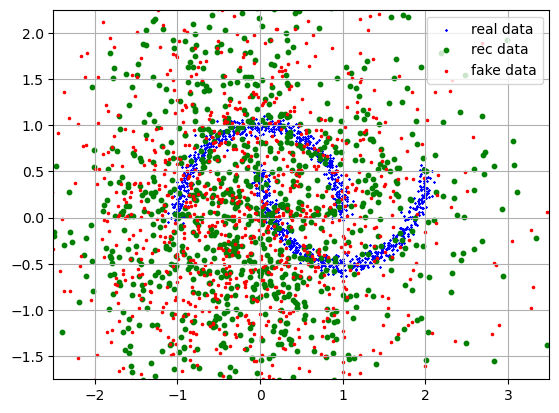

In [14]:
# Total number of training iterations for the VAE
N_ITER = 40000
# Batch size to use
BATCHLEN = 128

encoder = Encoder().to(device)
optim_enc = torch.optim.Adam(encoder.parameters(), lr=1e-3, betas=(0.5,0.9))
decoder = Decoder().to(device)
optim_dec = torch.optim.Adam(decoder.parameters(), lr=1e-3, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN).to(device)
    
    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    loss_kl = - 0.5 * torch.sum( 1 + enc_logvar - enc_mu**2 - enc_logvar.exp())

    #
    # SAMPLE z FROM q(z|x) HERE
    #
    # reparametrize trick
    epsilon = torch.randn_like(enc_mu)
    z = enc_mu + torch.exp(0.5 * enc_logvar) * epsilon
    
    # decode z
    dec_mu, dec_logvar = decoder(z)
    
    # x_hat = dec_mu
    x_hat = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    loss_rec = torch.mean( torch.sum((x-x_hat)**2, axis=1 ) )
    #
    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if (i+1)%5000 == 0:
        print(f"step {i+1} / {N_ITER} -- Total loss = {float(loss_kl+loss_rec):.4e} -- KL: {float(loss_kl):.4e} -- rec: {float(loss_rec):.4e}")

display_results()

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

step 5000 / 40000 -- Total loss = 3.9462e-03 -- KL: 3.1950e-03 -- rec: 7.5116e-04
step 10000 / 40000 -- Total loss = 1.8300e-03 -- KL: 1.6156e-03 -- rec: 2.1440e-04
step 15000 / 40000 -- Total loss = 1.3644e-03 -- KL: 1.1885e-03 -- rec: 1.7589e-04
step 20000 / 40000 -- Total loss = 1.2955e-03 -- KL: 1.1337e-03 -- rec: 1.6174e-04
step 25000 / 40000 -- Total loss = 1.2563e-03 -- KL: 1.1277e-03 -- rec: 1.2855e-04
step 30000 / 40000 -- Total loss = 1.2860e-03 -- KL: 1.1264e-03 -- rec: 1.5960e-04
step 35000 / 40000 -- Total loss = 1.2900e-03 -- KL: 1.1255e-03 -- rec: 1.6449e-04
step 40000 / 40000 -- Total loss = 1.2636e-03 -- KL: 1.1241e-03 -- rec: 1.3954e-04


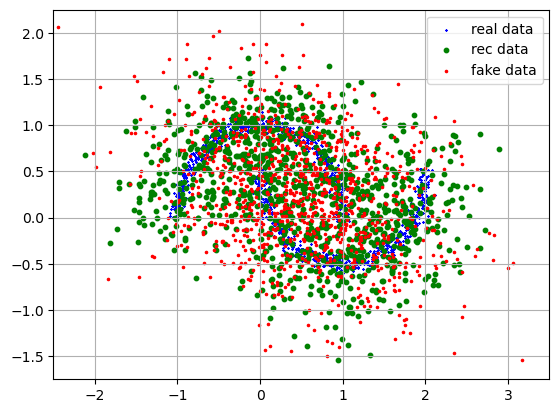

In [15]:
# Total number of training iterations for the VAE
N_ITER = 40000
# Batch size to use
BATCHLEN = 128

KL_WEIGHT = 1e-6
PARAM_NOISE = 1e-4

encoder = Encoder().to(device)
optim_enc = torch.optim.Adam(encoder.parameters(), lr=1e-3, betas=(0.5,0.9))
decoder = Decoder().to(device)
optim_dec = torch.optim.Adam(decoder.parameters(), lr=1e-3, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN).to(device)
    
    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    # kl_loss = - 0.5 * torch.sum( 1 + logvar - mean**2 - logvar.exp())
    loss_kl = KL_WEIGHT * (- 0.5 * torch.sum( 1 + enc_logvar - enc_mu**2 - enc_logvar.exp()))
    #

    #
    # SAMPLE z FROM q(z|x) HERE
    #
    # reparametrize trick
    epsilon = torch.randn_like(enc_mu) 
    z = enc_mu + torch.exp(0.5 * enc_logvar) * epsilon
    
    # decode z
    dec_mu, dec_logvar = decoder(z)
    # hardcoding noise
    x_hat = dec_mu + PARAM_NOISE * torch.randn_like(dec_mu) * torch.exp(0.5*dec_logvar)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    loss_rec = torch.mean( torch.sum((x-x_hat)**2, axis=1 ) )
    #
    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if (i+1)%5000 == 0:
        print(f"step {i+1} / {N_ITER} -- Total loss = {float(loss_kl+loss_rec):.4e} -- KL: {float(loss_kl):.4e} -- rec: {float(loss_rec):.4e}")
        
display_results()

<style>
    .cyan {
        background-color: #33f6ff;
    }
    
</style>

<span style="color:black">

<div class="cyan">

The training of the VAE requires an arbitrage between:
* the overall level of noise $\sigma_{\theta}$ that is used to sample $\hat{x}$ from the observation model (decoder)
* the weight of the KL loss and the reconstruction loss
  
</div>
</span>

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

<style>
    .cyan {
        background-color: #33f6ff;
    }
    
</style>

<span style="color:black">

<div class="cyan">

In our experiments, the KL_WEIGHT parameter allows to tune the relative strength of the encoder vs the decoder.
* when KL_WEIGHT is small (around 1e-4 or below), the training of the VAE is mostly done on encoding a relevant value of $\mu_{\phi}(x)$ and a good reconstruction error. The VAE behaves mostly like an AutoEncoder.
* when KL_WEIGHT is big (around 1e-3 or above), the training of the VAE focuses much more on the KL, ie on mapping $q_{\phi}$ to a Gaussian $\mathcal{N}(0, \text{Id})$. The generator part of the VAE receives more emphasis, and the reconstruction error can increase, especially if the noise level in the samplings is significant.
  
</div>
</span>

**Q13 bis - changing VAE architecture to try to improve training** - we beef up the encoder and decoder (adding linear layers to increase expressivity), go to GPU to speed things up, keep the latent dimension.

In [16]:
torch.set_default_dtype(torch.float32)

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(f"Using {device}")

!nvidia-smi # if using RTX at IRT

# set seeds for reproductibility
random_seed = 42
rng = np.random.default_rng(seed=random_seed)
torch.manual_seed(random_seed)

Using cuda
Sun Mar 30 20:00:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        Off |   00000000:01:00.0 Off |                  N/A |
|  0%   59C    P2             95W /  370W |     319MiB /  10240MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------------------------

In [17]:
# Choose a value for the latent dimension
LATENT_N = 16

# Define the generator
class BigEncoder(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.fc11 = nn.Linear(2, hidden_dim)
        self.fc12 = nn.Linear(hidden_dim, hidden_dim)
        self.fc13 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim,LATENT_N)
        
        self.fc21 = nn.Linear(2, hidden_dim)
        self.fc22 = nn.Linear(hidden_dim, hidden_dim)
        self.fc23 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_logvar = nn.Linear(hidden_dim, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, inputs):
        # compute mu
        x = F.relu(self.fc11(inputs))
        x = F.relu(self.fc12(x))
        x = F.relu(self.fc13(x))
        mu = self.fc_mu(x)
        # compute logvar
        x = F.relu(self.fc21(inputs))
        x = F.relu(self.fc22(x))
        x = F.relu(self.fc23(x))
        logvar = self.fc_logvar(x)
        # return both
        return (mu, logvar)
    

# Define the discriminator
class BigDecoder(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        
        self.fc11 = nn.Linear(LATENT_N, hidden_dim)
        self.fc12 = nn.Linear(hidden_dim, hidden_dim)
        self.fc13 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, 2)
        
        self.fc21 = nn.Linear(LATENT_N, hidden_dim)
        self.fc22 = nn.Linear(hidden_dim, hidden_dim)
        self.fc23 = nn.Linear(hidden_dim, hidden_dim)     
        self.fc_logvar = nn.Linear(hidden_dim, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        # compute mu
        x = F.relu(self.fc11(z))
        x = F.relu(self.fc12(x))
        x = F.relu(self.fc13(x))
        mu = self.fc_mu(x)
        # compute logvar
        x = F.relu(self.fc21(z))
        x = F.relu(self.fc22(x))
        x = F.relu(self.fc23(x))
        logvar = self.fc_logvar(x)
        # return both
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0).to(device)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

step 5000 / 40000 -- Total loss = 3.2368e-01 -- KL: 2.2311e-01 -- rec: 1.0057e-01
step 10000 / 40000 -- Total loss = 2.9714e-01 -- KL: 2.1891e-01 -- rec: 7.8237e-02
step 15000 / 40000 -- Total loss = 3.1449e-01 -- KL: 2.2166e-01 -- rec: 9.2830e-02
step 20000 / 40000 -- Total loss = 3.2033e-01 -- KL: 2.2017e-01 -- rec: 1.0016e-01
step 25000 / 40000 -- Total loss = 3.1385e-01 -- KL: 2.2665e-01 -- rec: 8.7201e-02
step 30000 / 40000 -- Total loss = 3.1629e-01 -- KL: 2.2285e-01 -- rec: 9.3438e-02
step 35000 / 40000 -- Total loss = 3.0559e-01 -- KL: 2.2757e-01 -- rec: 7.8015e-02
step 40000 / 40000 -- Total loss = 3.2174e-01 -- KL: 2.2317e-01 -- rec: 9.8569e-02


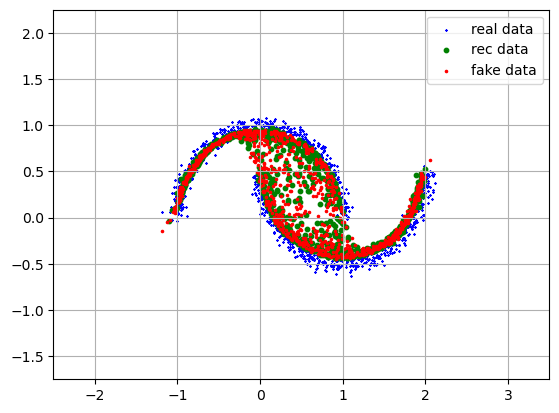

In [26]:
# Total number of training iterations for the VAE
N_ITER = 40000
# Batch size to use
BATCHLEN = 128

KL_WEIGHT = 1e-3
PARAM_NOISE = 1.0

encoder = BigEncoder().to(device)
optim_enc = torch.optim.Adam(encoder.parameters(), lr=1e-4, betas=(0.5,0.9))
decoder = BigDecoder().to(device)
optim_dec = torch.optim.Adam(decoder.parameters(), lr=1e-4, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN).to(device)
    
    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    # kl_loss = - 0.5 * torch.sum( 1 + logvar - mean**2 - logvar.exp())
    loss_kl = KL_WEIGHT * (- 0.5 * torch.sum( 1 + enc_logvar - enc_mu**2 - enc_logvar.exp()))
    #

    #
    # SAMPLE z FROM q(z|x) HERE
    #
    # reparametrize trick
    epsilon = torch.randn_like(enc_mu) 
    z = enc_mu + torch.exp(0.5 * enc_logvar) * epsilon
    
    # decode z
    dec_mu, dec_logvar = decoder(z)
    # hardcoding noise
    x_hat = dec_mu + PARAM_NOISE * torch.randn_like(dec_mu) * torch.exp(0.5*dec_logvar)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    loss_rec = torch.mean( torch.sum((x-x_hat)**2, axis=1 ) )
    #
    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if (i+1)%5000 == 0:
        print(f"step {i+1} / {N_ITER} -- Total loss = {float(loss_kl+loss_rec):.4e} -- KL: {float(loss_kl):.4e} -- rec: {float(loss_rec):.4e}")
        
display_results()

---
## Flow Matching

Another approach to generative modeling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

For the implementation we will use Flow Matching, an approach for training Continuous Normalizing Flows based on regressing vector fields of fixed conditional probability paths.
Before diving into Flow Matching, let’s first clarify:

- A **vector field** is a mathematical object that assigns a vector to every point in a space. We can think of it as a function that describes the direction and speed of movement at every possible location.

- A **flow** is the trajectory that a point follows when it moves according to the directions given by the vector field over time. In general, data points evolve when guided by a vector field.


Let us denote $\renewcommand{\R}{\mathbb{R}} v : [0,1] \times \R^d \to \R^d $ a time-dependent vector field and $\phi : [0,1] \times \R^d \to \R^d$ a flow. A flow is related to a vector field $v_t$ as:
$$
\frac{d}{dt}\phi_t(x) = v_t(\phi_t(x))
$$
$$
\phi_0(x) = x
$$

The main idea of Flow Matching is to use a neural network to model the vector field $v_t$, which implies that $\phi_t$ will also be a parametric model simulating a Continuous Normalizing Flow (CNF). In the context of generative modeling, the CNF allows us to transform a simple prior distribution (e.g. Gaussian) $p_z$ into a more complex one $p_x$, which will be hopefully close enough to the data distribution $p_D$. To comply with the time-dependent framework, we assume a transition between $p_z$ and $p_x$ in a range $[0,1]$ so $p_z = p_0$ and $p_x = p_1$. We proceed by using the push-forward equation:
$$
p_t = [\phi_t]*p_0
$$
where $\forall x \in \R^2$:
$$
[\phi_t]*p_0(x) := p_0(\phi^{-1}(x)) \; \det\Big[ \frac{\delta \phi_t^{-1}}{\delta x} (x) \Big]
$$

So the flow $\phi$ acts as the mapping $f$ in this context. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$. 

Thus Flow Matching aims to learn the true vector field $u_t$:
$$
L_{CFM}(\theta) = \mathbb{E}_{t,p_D(x_1),p_t(x|x_1)} || v_t(x) - u_t(x|x_1) ||^2
$$
> **Attention! Mind the difference in notation between the true vector $u$ and its estimation $v$.**

### Optimal Transport Conditional Vector Fields

We will use the simplest approach where the flow $\phi$ is a linear displacement.

Let $x_1 \sim p_D(x_1)$ be a point from the dataset. We can define the conditional flow $\psi_t$ (conditional version of $\phi_t$) to be the Optimal Transport displacement map between the two Gaussians $p_0(x|x_1)$ and $p_1(x|x_1)$, that is: 
\begin{equation}
\psi_t(x) = (1 - (1 - \sigma_{min})t)x + tx_1
\end{equation}
(we can prove that $\psi_t$ satisfies the push-forward equation).

In the case of Optimal Transport conditional VFs the conditional flow matching objective loss can be written as follows: 
$$
L_{CFM}(\theta) = \mathbb{E}_{t,p_D(x_1),p(x_0)} ||v_t(\psi_t(x_0)) - \frac{d}{dt}\psi_t(x_0)||^2
$$

**Q14: Express the derivative of $\psi_t(x_0)$, to simplify the formula of $L_{CFM}(\theta)$.**

> (Write your answer here)

**Q15: Calculate the determinant of the Jacobian of the flow $\phi_t(x)$.**

> (Write your answer here)

**Q16: Using the Jacobian determinant, prove that $\psi_t(x)$ is indeed invertible.**

> (Write your answer here)

**Q17: Prove that $\psi_t(x)$ satisfies the push-forward equation. That means that it applies scaling and shifting to the distribution $p_0(x)$.**

> (Write your answer here)

We sample $x_1 \sim p_D(x_1)$ (samples from the dataset), $x_0 \sim p(x_0)$ (samples from the prior distribution) and $t \sim \text{Unif}([0,1])$. We need to apply a little trick for time sampling since the batch covers the range $[0,1]$ uniformly with a random offset. Then we compute an approximation of the CFM Loss on the batch:
$$
L_{batch}(\theta) = \frac{1}{N} \sum_{i=0}^{N-1} ||v_t(\psi_t(x_0^{(i)})) - (x_1^{(i)} - (1 - \sigma_{min})x_0^{(i)})||^2
$$

**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [19]:
class OptimalTransportFlowMatching:
    def __init__(self, sig_min: float = 0.001) -> None:
        super().__init__()
        self.sig_min = sig_min
        self.eps = 1e-5

    def psi_t(self, x: torch.Tensor, x_1: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """ Conditional Flow
        """
        #
        # COMPUTE THE CONDITIONAL FLOW HERE
        #
        return None

    def loss(self, v_t: nn.Module, x_1: torch.Tensor) -> torch.Tensor:
        """ Compute loss
        """
        # t ~ Unif([0, 1])
        # the batch covers the range [0,1] uniformly with a random offset
        t = (torch.rand(1, device=x_1.device) + torch.arange(len(x_1), device=x_1.device) / len(x_1)) % (1 - self.eps)
        t = t[:, None].expand(x_1.shape) # turn 2d
        
        #
        # SAMPLE THE PRIOR DISTRIBUTION HERE
        # x_0 ~ p(x_0)
        #
        
        #
        # CALCULATE THE BATCH LOSS HERE
        #
        return None

### Conditional Vector Field

We add the Conditional Vector Field class which aims to model the Optimal Transport Conditional Vector Field $v_t$. This approximation $v_t(\cdot;\theta)$ of the true $v_t$ will be optimized by tuning the parameters $\theta$ of ConditionalVectorField.

Once optimized, we need to sample from the learned flow, thus we define the encode and decode functions:
- `encode` maps the data distribution $p_D(x_1) \approx p_1(x_1)$ to the prior distribution $p(x_0)$.
- `decode` maps the prior distribution $p(x_0)$ to the data distribution $p_1(x_1) \approx p_D(x_1)$.

A flow $\phi_t$ and its corresponding vector field $v_t$ verify the following equations:
$$
\frac{d}{d_t}\phi_t(x) = v_t(\phi_t(x))
$$
$$
\phi_0(x) = x
$$
Thus, to encode we integrate the first equation from $t=1$ to $t=0$ and the decode function is the same but going from $t=0$ to $t=1$.
We use the Euler method to encode and decode.

In [20]:
class ConditionalVectorField(nn.Module):
    def __init__(self, net: nn.Module, n_steps: int = 100, dt: float = 0.01) -> None:
        super().__init__()
        self.net = net
        self.n_steps = n_steps
        self.dt = dt

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return self.net(t, x)
        
    def wrapper(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        t = t * torch.ones(len(x), device=x.device)
        return self(t, x)

    def encode(self, x_1: torch.Tensor) -> torch.Tensor:
        x = x_1
        t = torch.ones(x.shape[0], device=x.device)  # Start from t=1
        for _ in range(self.n_steps):
            v = self.wrapper(t, x)
            x = x - self.dt * v  # Reverse Euler update
            t = t - self.dt  # Decrement time
        return x

    def decode(self, x_0: torch.Tensor) -> torch.Tensor:
        x = x_0
        t = torch.zeros(x.shape[0], device=x.device)
        for _ in range(self.n_steps):
            v = self.wrapper(t, x)
            x = x + self.dt * v # Euler update
            t = t + self.dt # Step increment
        return x

### Neural Network for VF approximation

We want to approximate $v_t$ with a parametric model $v_t(\cdot;\theta)$. Since we deal with point coordinates and want to keep the neural network simple for this example, we use a simple Multilayer Perceptron.

However the vector field $v$ is conditioned on time $t$. Thus, we create a sinusoidal positional encoding of $t$ thanks to sine and cosine functions to have a time representation that is easier to exploit than just its value between 0 and 1.

When computing $v_t(x)$ we simply concatenate the sinusoidal positional encoding of $t$ with $x$ (input coordinates), and then process the obtained tensor with the MLP's layers.

In [21]:
class Net(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, h_dims: list[int], n_frequencies:int) -> None:
        super().__init__()
        ins = [in_dim + 2 * n_frequencies] + h_dims
        outs = h_dims + [out_dim]
        self.n_frequencies = n_frequencies

        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(in_d, out_d), nn.LeakyReLU()) for in_d, out_d in zip(ins, outs)
        ])
        self.top = nn.Sequential(nn.Linear(out_dim, out_dim))
    
    def time_encoder(self, t: torch.Tensor) -> torch.Tensor:
        freq = 2 * torch.arange(self.n_frequencies, device=t.device) * torch.pi
        t = freq * t[..., None]
        return torch.cat((t.cos(), t.sin()), dim=-1)
        
    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        t = self.time_encoder(t)
        x = torch.cat((x, t), dim=-1)
        
        for l in self.layers:
            x = l(x)
        return self.top(x)

### Train

In [22]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
N_LAYERS = 5
TIME_FREQUENCY = 10

In [23]:
# data loading
train_data = generate_batch(50000)
test_data = generate_batch(1000)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
model = OptimalTransportFlowMatching()
net = Net(INPUT_SIZE, OUTPUT_SIZE, [HIDDEN_SIZE]*N_LAYERS, TIME_FREQUENCY).to(device)
v_t = ConditionalVectorField(net)    

losses = [] 
# configure optimizer
optimizer = torch.optim.Adam(v_t.parameters(), lr=1e-3)
n_epochs = 5000

for epoch in range(N_EPOCHS):
    for batch_idx, x_inputs in enumerate(train_loader):
        x_1 = x_inputs.to(device)
        # compute loss 
        loss = model.loss(v_t, x_1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses += [loss.detach()]
        if batch_idx % LOG_INTERVAL == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_data),
                100. * batch_idx / len(train_loader), loss / len(x_inputs)))


### Sampling

To sample $\hat{x}_1 \sim p_D(x_1)$, we first sample $x_0 \sim p(x)$, drawing samples from the prior distribution, and then apply the decode function from the ConditionalVectorField class.

In [ ]:
# 
# SAMPLE THE PRIOR AND DECODE HERE
#

In [ ]:
#
# PLOT THE DENSITY HERE
#

**Q19: Explain why Normalizing flows do not fit well when there are many clusters in the data.**

> (Write your answer here)

---
## Denoising Diffusion Model

Recently Diffusion Models received a lot of attention. __Diffusion Models Beat GANs on Image Synthesis__ *(Dhariwal,Nichol)* : [arXiv:2105.05233](https://arxiv.org/pdf/2105.05233.pdf) shows significant improvement on image generation with a model claimed to be easier to train than GANs.


It is the key of the image generating process behind Latent Diffusion models such as Dall.e, Imagen or StableDiffusion. 

We are going to implement a model inspired by the paper
__Denoising Diffusion Probabilistic Models__  *(Ho et al.)*: [arXiv:2006.11239](https://arxiv.org/pdf/2006.11239.pdf) 


 Denoising diffusion probabilistic model  introduce noise into data and gradually learn to reverse this process for generating new samples. It involves two Markov chains, one that forwards data to noise, and another that reverses this process by converting the noise back to data. The forward chain is usually designed to transform any data distribution into a simpler prior distribution, such as a standard Gaussian distribution, while the reverse Markov chain is parametrized by a neural network and learns to reverse this process. To generate new data points, we first sample a random vector from the prior distribution, then applies ancestral sampling through the reverse Markov chain.

 References:

- Survey on Diffusion Models : https://arxiv.org/pdf/2209.00796.pdf
- https://lilianweng.github.io/posts/2021-07-11-diffusion-models/
- https://blog.alexalemi.com/diffusion.html
- https://sander.ai/posts/



![Denoisingdiagram](./illustrationDenoising.png)

$q$ and $p_{\theta}$ being the respective kernels of the two chains. 


#### Forward Pass ####

For our purpose we are going to use a Gaussian Noise. The forward Kernel will have the following shape : 

$$q(x_t| x_{t-1}) = \mathcal{N}(x_t;\sqrt{1- \beta_t} x_{t-1},\beta_t I )$$

with $\mathcal{N}(x;\mu,\sigma I )$ a conditional gaussian :
$$ y \sim \mathcal{N}(x;\mu,\sigma I ) \equiv y|x \sim  \mathcal{N}(\mu,\sigma I )$$

**Q20: What does $\beta_t$ represent in the formula ?**

> (Write your answer here)

In our example the sequence $\beta_t$ will be chosen linearly wrt $t$. 

We introduce $\alpha_t := 1-\beta_t$ and $\overline{\alpha_t} = \prod_{s=1}^{t} \alpha_s$ we can sample forward directly at timestep $t$ from the original image : 
$$q(\mathbf{x}_{1:T}|\mathbf{x}_0) = \prod_{t=1}^{T}q(\mathbf{x}_t|\mathbf{x}_{t-1})$$
$$ q(\mathbf{x}_t| \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t;\sqrt{\overline{\alpha_t}} \mathbf{x}_0, (1-\overline{\alpha_t})I)$$

i.e. 
\begin{align}
\boldsymbol{x}_t = \sqrt{\bar{\alpha}_t} \boldsymbol{x}_0 + \sqrt{1 - \bar{\alpha}_t} \boldsymbol{\epsilon} \;\;\; \text{where} \; \boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
\end{align}

we will then fix $$\sigma_t = \sqrt{1 - \bar{\alpha}_t}$$

**Q22:  Implement the forward pass using $\overline{\alpha_t}$ (Hint : you may need to precalculate the $\overline{\alpha_t}$ from $\beta_t$)**

In [ ]:
def bcast_right(x: torch.Tensor, ndim: int) -> torch.Tensor:
    """Util function for broadcasting to the right."""
    if x.ndim > ndim:
        raise ValueError(f'Cannot broadcast a value with {x.ndim} dims to {ndim} dims.')
    elif x.ndim < ndim:
        difference = ndim - x.ndim
        return x.view(x.shape + (1,) * difference)
    else:
        return x


In [ ]:
class DiscreteDDPMProcess:
    """A Gaussian diffusion process: q(xt|x0) = N(sqrt_alpha_bar(t)*x0, sigma(t)^2 * I),
    which implies the following transition from x0 to xt:

    xt = sqrt_alpha_bar(t) x0 + sigma(t) eps, eps ~ N(0, I).

    Diffusion processes differ in how they specify sqrt_alpha_bar(t) and/or sigma(t).
    Here we follow the DDPM paper.

    """
    def __init__(
        self,
        num_diffusion_timesteps: int = 1000,
        beta_start: float = 0.0001,
        beta_end: float = 0.02,
    ):
        self._num_diffusion_timesteps = num_diffusion_timesteps
        self._beta_start = beta_start
        self._beta_end = beta_end
        self._betas = np.linspace(self._beta_start, self._beta_end, self._num_diffusion_timesteps)

        alphas_bar = self._get_alphas_bar()
        ###############
        # TO COMPLETE #
        ###############
        self._sqrt_alphas_bar = ? #put in dtype=torch.float32
        self._sigmas = ? #put in dtype=torch.float32

    @property
    def tmin(self):
        return 1

    @property
    def tmax(self):
        return self._num_diffusion_timesteps

    def _get_alphas_bar(self) -> np.ndarray:
        ###############
        # TO COMPLETE #
        ###############
        alphas_bar = ?

        # we can add this 1 in front to simplify indexing,
        # and to make alpha[0]=1 and sigma[0]=0.
        # these values at t=0 will be needed later when generating samples
        alphas_bar = np.concatenate(([1.], alphas_bar))

        return alphas_bar

    def sqrt_alpha_bar(self, t: torch.Tensor) -> torch.Tensor:
        return self._sqrt_alphas_bar[t.long()]

    def sigma(self, t: torch.Tensor) -> torch.Tensor:
        return self._sigmas[t.long()]

    def sample(self, x0: torch.Tensor, t: torch.Tensor, eps: torch.Tensor) -> torch.Tensor:
        """Draws samples from the forward diffusion process q(xt|x0)."""
        ###############
        # TO COMPLETE #
        ###############
        return 

In [ ]:
# data loading
test_data = generate_batch(1000)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
process = DiscreteDDPMProcess(num_diffusion_timesteps=1000)
ts = torch.Tensor(np.linspace(process.tmin, process.tmax, num=process.tmax, dtype=np.int32))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(4 * 2, 2))

# plot how sqrt_alpha_bar and sigma change over time
ax[0].plot(ts.numpy(), process.sigma(ts), label=r'$\sigma$')
ax[0].plot(ts.numpy(), process.sqrt_alpha_bar(ts), label=r'$\sqrt{\bar\alpha}$')
ax[0].set_xlabel('time')
ax[0].legend()

# It is often helpful to reason in terms of signal-to-noise ratio:
# SNR = sqrt_alpha_bar(t)^2 / sigma(t)^2 or more conveniently, its logarithm.
# High SNR = little noise, low SNR = a lot of noise.
lambda_ = [2. * np.log(process.sqrt_alpha_bar(t) / process.sigma(t)) for t in ts]
ax[1].plot(ts.numpy(), lambda_, c='g', label=r'$log SNR$')
ax[1].set_xlabel('time')
ax[1].legend()

plt.show()

In [ ]:
# Effect on the distribution
torch_test_data = torch.Tensor(test_data)
def apply_on_dataset(dataset,t):
    dataset_t = torch.zeros_like(dataset)
    for i in range(dataset.shape[0]):
        point = dataset[i]
        eps = torch.randn_like(point)
        point_t = process.sample(point, t, eps)
        dataset_t[i] = point_t
    return dataset_t

fig,axes = plt.subplots(1,5,figsize=(20,5))
axes[0].scatter(torch_test_data[:,0],torch_test_data[:,1])
for i in range(1,5):
    t = torch.Tensor([i*50]).type(torch.int64)
    dataset_t = apply_on_dataset(torch_test_data,t)
    axes[i].scatter(dataset_t[:,0],dataset_t[:,1])
    axes[i].set_title(f"After {t.detach().item()} walks")
fig.suptitle("Influence of the forward pass on the distribution")
plt.show()



#### Backward Process

Hypothetically, We would like  to train the reverse kernel $p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)$, with parameters $\theta$ parametrized by a neural network 

$$
p_\theta\left(\mathbf{x}_{0: T}\right):=p\left(\mathbf{x}_T\right) \prod_{t=1}^T p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)
$$

with $p(\mathbf{x}_T)$ a Gaussian prior, $p(\mathbf{x}_T) \sim \mathcal{N}(0,I)$ . We would use $p(\mathbf{x}_T)$ to sample new data points for generation.

#### Variational Lower Bound 

In the paper, they used the knowledge of the forward pass and design a  Gaussian  reverse kernel

$$
p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)=\mathcal{N}\left(\mathbf{x}_{t-1} ; \mu_\theta\left(\mathbf{x}_t, t\right), \Sigma_\theta\left(\mathbf{x}_t, t\right)\right)
$$

with $\mu_{\theta}$ and $\Sigma_{\theta}$  parametrized by a neural network

We can write the previous forward kernel
$$
\begin{aligned}
q\left(\mathbf{x}_t \mid \mathbf{x}_0\right) & =\mathcal{N}\left(\mathbf{x}_t ; \sqrt{\bar{\alpha}_t} \mathbf{x}_0,\left(1-\bar{\alpha}_t\right) \mathbf{I}\right) \\
& =\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\epsilon \sqrt{1-\bar{\alpha}_t}
\end{aligned}
$$
with $ \epsilon \sim \mathcal{N}(0, \mathbf{I})$ 

The natural loss would be to optimize under the variational lower bound $L_t$ such that : 
$$
\begin{aligned}
L_{\mathrm{vlb}} & :=L_0+L_1+\ldots+L_{T-1}+L_T \\
L_0 & :=-\log p_\theta\left(x_0 \mid x_1\right) \\
L_{t-1} & :=D_{K L}\left(q\left(x_{t-1} \mid x_t, x_0\right) \| p_\theta\left(x_{t-1} \mid x_t\right)\right) \\
L_T & :=D_{K L}\left(q\left(x_T \mid x_0\right) \| p\left(x_T\right)\right)
\end{aligned}
$$

One can show that an alternative loss can be used that only take one parametrized estimator $\epsilon_{\theta}$. \
Hint: KL divergences between Gaussian distributions can be computed analytically
$$
L_{\text {simple }}(\theta):=\mathbb{E}_{t, \mathbf{x}_0, \boldsymbol{\epsilon}}\left[\left\|\boldsymbol{\epsilon}-\boldsymbol{\epsilon}_\theta\left(\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\sqrt{1-\bar{\alpha}_t} \boldsymbol{\epsilon}, t\right)\right\|^2\right]
$$

Let's start implementing the network that predicts $\widehat \epsilon(x_t, t; \theta)$. Note that, as stated by its definition, $\epsilon$ is the cumulated noise from $t=0$ and not just the noise added at the last step.

In [ ]:
import torch.nn as nn

class ResidualMLP(nn.Module):
    """MLP with residual connections."""

    def __init__(
        self,
        n_blocks: int,
        n_hidden: int,
        n_out: int,
        activation: str,
        name: str = None
    ):
        super(ResidualMLP, self).__init__()
        self._n_blocks = n_blocks
        self._n_hidden = n_hidden
        self._n_out = n_out
        self._activation = getattr(nn.functional, activation)

        self.linear_input = nn.Linear(n_out, n_hidden)
        self.linear_time = nn.ModuleList([nn.Linear(n_hidden, n_hidden) for _ in range(self._n_blocks)])
        self.linear_hidden = nn.Sequential(
    nn.ModuleList([nn.Linear(n_hidden, n_hidden) for _ in range(self._n_blocks)]),
    nn.ModuleList([nn.Linear(n_hidden, n_hidden) for _ in range(self._n_blocks)])
        )
        self.linear_output = nn.Linear(n_hidden, n_out)

    def forward(self, xt: torch.Tensor, time: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(xt)

        for _ in range(self._n_blocks):
            h=self._activation(x)
            h=self.linear_hidden[_][0](h)
            h=h+self.linear_time[_](time)
            h=self._activation(h)
            h=self.linear_hidden[_][1](h)
            x=x+h

        outputs = self.linear_output(x)

        return outputs


#### Time embeddings

As we can see above, the denoiser network needs to get timestep $t$ as an input.

However, feeding integers $t=1, 2, ... T$ into the network will not work.

[Transformers](https://arxiv.org/abs/1706.03762), when faced with the same problem, proposed to embed timesteps into $d$-dimensional vectors of sinusoids:

$$e = [\; \sin(w_1 t) \; \; \cos(w_1 t) \; ... \; \sin(w_{d/2} t) \; \; \cos(w_{d/2} t) \;]$$

with $w_i = 1/ 10000^{\frac{2i}{d}}$.

Here is nice blogpost with more intuition: https://kazemnejad.com/blog/transformer_architecture_positional_encoding/


In [ ]:
class SinusoidalTimeEmbedding(nn.Module):
    """Time (positional) embedding as in Transformers."""

    def __init__(self, num_features: int, name: str = None):
        super(SinusoidalTimeEmbedding, self).__init__()
        self._num_features = num_features

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        assert len(inputs.shape) == 1
        half_dim = self._num_features // 2
        e = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        embedding = torch.exp(-e * torch.arange(half_dim).float()).to(device)
        embedding = inputs.view(-1, 1) * embedding
        embedding = torch.cat([torch.cos(embedding), torch.sin(embedding)], dim=-1)
        if self._num_features % 2 == 1:
            embedding = nn.functional.pad(embedding, (0, 1))
        return embedding


Now we need to put the two modules together:

In [ ]:
import dataclasses

@dataclasses.dataclass
class NetConfig:
    resnet_n_blocks: int = 2
    resnet_n_hidden: int = 256
    resnet_n_out: int = 2
    activation: str = 'elu'
    time_embedding_dim: int = 256


class Net(nn.Module):
    """Combines MLP and time embeddings."""
    def __init__(self, net_config: NetConfig, name: str = None):
        super(Net, self).__init__()

        self._time_encoder = SinusoidalTimeEmbedding(net_config.time_embedding_dim)
        self._predictor = ResidualMLP(
            n_blocks=net_config.resnet_n_blocks,
            n_hidden=net_config.resnet_n_hidden,
            n_out=net_config.resnet_n_out,
            activation=net_config.activation
        )

    def forward(self, noisy_data: torch.Tensor, time: torch.Tensor) -> torch.Tensor:
        time_embedding = self._time_encoder(time)
        outputs = self._predictor(noisy_data, time_embedding)
        return outputs


#### Time sampler

To compute our loss function, for each example, we need to sample a random timestep. In this trivial case of uniform sampling between step 1 and T, it might be an overkill to implement it as a separate class. It would be more helpful if you're going to explore more exotic diffusion models.

In [ ]:
from typing import Sequence

class UniformDiscreteTimeSampler:

    def __init__(self, tmin: int, tmax: int):
        self._tmin = tmin
        self._tmax = tmax

    def sample(self, shape: Sequence[int]) -> torch.Tensor:
        return torch.randint(low=self._tmin, high=self._tmax, size=shape)


#### Full DDPM model

**Q.23 Implement the Simplified loss given a model $\epsilon_{\theta}$**

In [ ]:
class DiffusionModel(nn.Module):
    """Diffusion model."""

    def __init__(self, diffusion_process, time_sampler, net_config, data_shape):
        super(DiffusionModel, self).__init__()

        self._process = diffusion_process
        self._time_sampler = time_sampler
        self._net_config = net_config
        self._data_shape = data_shape
        self.net_fwd = Net(net_config)

    def loss(self, x0: torch.Tensor) -> torch.Tensor:
        """Computes MSE between the true noise and predicted noise,
        i.e. the goal of the network is to correctly predict eps from a noisy observation
        xt = alpha(t) * x0 + sigma(t)**2 * eps"""

        ###############
        # TO COMPLETE #
        ###############

        t = ?  # sample time

        eps = ?  # sample noise

        xt = ?  # corrupt the data

        net_outputs = ?  # get net outputs

        loss = ?  # compute MSE loss between predicted and true noise

        return loss

    #Used for sampling 
    def _reverse_process_step(
        self,
        xt: torch.Tensor,
        t: int,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Computes parameters of a Gaussian p_{\theta}(x_{t-1}| x_t)."""

        t = t * torch.ones((xt.shape[0],), dtype=torch.int32, device=xt.device)

        ###############
        # TO COMPLETE #
        ###############

        eps_pred = ?  # predict epsilon from x_t

        sqrt_alpha_t = ? # use self._sqrt_alpha_bar
        inv_sqrt_alpha_t = bcast_right(1.0 / sqrt_alpha_t, xt.ndim)

        beta_t = ?
        beta_t = bcast_right(beta_t, xt.ndim)

        inv_sigma_t = ?
        inv_sigma_t = bcast_right(inv_sigma_t, xt.ndim)

        mean = ?

        # DDPM instructs to use either the variance of the forward process
        # or the variance of q(x_{t-1}|x_t, x_0). Former is easier.
        std = ?

        eps = ?

        return ?


    def sample(self, x0, sample_size):
    """To generate samples from DDPM, we follow the reverse process.
    At each step of the chain, we sample x_{t-1} from p(x_{t-1}| x_t, x0_pred) until we get to x_0."""
        with torch.no_grad():
            x = torch.randn((sample_size,) + self._data_shape, device=x0.device) #sample pure noise

            
            ###############
            # TO COMPLETE #
            ###############

        return x

Given the noise obtained by the model $\boldsymbol{\epsilon}_\theta\left(\mathbf{x}_t, t\right)$, you can sample $\mu_{\theta}(\mathbf{x}_t,t)$ in order to get a denoised sample point.
$$
\mu_{\theta}(\mathbf{x}_t,t) = \frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta\left(\mathbf{x}_t, t\right)\right)
$$ 


The _reverse_process_step function sample $x_{t-1} \sim p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)$ where
$$
p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)=\mathcal{N}\left(\mathbf{x}_{t-1} ; \mu_\theta\left(\mathbf{x}_t, t\right), \Sigma_\theta\left(\mathbf{x}_t, t\right)\right)
$$
and we set $$\Sigma_\theta\left(\mathbf{x}_t, t\right) = \beta_{t}\boldsymbol{I}$$

Thus $$x_{t-1} = \mu_{\theta}(\mathbf{x}_t,t) + \sqrt{\beta_t}\epsilon$$ where $$\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$$

**Q.24 Build the sampling function that allows you from inputs $\mathbf{x}_t$ and $t$ to obtain $\mu_{\theta}(\mathbf{x}_t,t)$ and $x_{t-1}$**

#### Training

In [ ]:
from torch import optim

# create the model
diffusion_process = DiscreteDDPMProcess(num_diffusion_timesteps=1000)
time_sampler = UniformDiscreteTimeSampler(diffusion_process.tmin, diffusion_process.tmax)
model = DiffusionModel(diffusion_process, time_sampler, net_config=NetConfig(), data_shape=(2,)).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

We will use a learning rate scheduler with a warmup. \
You will have to install the library pytorch_warmup with "pip install -U pytorch_warmup": https://github.com/Tony-Y/pytorch_warmup \
Our learning rate schedule will have the following shape.

![Denoisingdiagram](./lr_with_warmup.png)

In [ ]:
import pytorch_warmup as warmup

training_steps = 50000

warmup_period=1000 #this is the increasing part of the learning rate schedule
num_steps = training_steps
t0 = num_steps // 1
lr_min = 3e-12
max_step = t0 * 1 + warmup_period #you can also create cycle but we won't touch it here

lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=t0, T_mult=1, eta_min=lr_min)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


##### Training loop

**Q.25 Train $\epsilon_{\theta}(\mathbf{x},t)$ that take as entry a transformed vector $\mathbf{x}$ and  $t$ a number of time $\mathbf{x}$ passed through the forward process  and return  a direct estimate of  the noise $\epsilon$**

In [ ]:
BATCH_SIZE=1024

for step in range(training_steps):
    #generate batch on the fly

    ###############
    # TO COMPLETE #
    ###############

    if step % 1000 == 0:
        print(f'Step: {step}, Loss: {loss:.5f}')

    if step % 10000 == 0:
        with torch.no_grad():
            samples = ? # create new samples
        plt.figure(figsize=(3, 3))
        plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5)
        plt.show()

    with warmup_scheduler.dampening():
        if warmup_scheduler.last_step + 1 >= warmup_period:
            lr_scheduler.step()
        if warmup_scheduler.last_step + 1 >= max_step:
            break


#### Ablation study

**Q.26 Perform ablations experiments on hyperparameters, such as: learning rate (try constant learning rate with different values), batch size, the number of timesteps, the positional embedding for timestep (remove it), the hidden size, number of epochs, skip connections**

For a given ablation experiment (they ought to be done separately!), you should plot generated samples at few given timesteps (if compute resources is limited, do it for one timestep).

Note: you don't have to do all of these experiments, but the bigger is your group, the more you should do.

> (Write your answer here)

#### Generation/Sampling

**Q.27  Generate samples and plot them at different timestep of the chain. Check how real & synthetic distribution overlap, compare the densities**

---
## Conclusion

**Q.28: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs, Flow Matching and Denoising Models ?**

> (Write your answer here)